## This Notebook details the models created for the research topic

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from functools import reduce
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import textwrap

Duplicate key in file '/Users/joshuaevans/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [138]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
forecastdemand_vic = pd.read_csv("../data/Australia/a/forecastdemand_vic.csv")
forecastdemand_sa = pd.read_csv("../data/Australia/b/forecastdemand_sa.csv")
forecastdemand_qld = pd.read_csv("../data/Australia/c/forecastdemand_qld.csv")
temperature_qld = pd.read_csv("../data/Australia/d/temprature_qld.csv")  # There's a typo in 'temperature' in the file path
temperature_sa = pd.read_csv("../data/Australia/d/temprature_sa.csv")  # Same typo as above
temperature_vic = pd.read_csv("../data/Australia/d/temprature_vic.csv")  # Same typo as above
totaldemand_qld = pd.read_csv("../data/Australia/d/totaldemand_qld.csv")
totaldemand_sa = pd.read_csv("../data/Australia/d/totaldemand_sa.csv")
totaldemand_vic = pd.read_csv("../data/Australia/d/totaldemand_vic.csv")

In [3]:
forecastdemand_qld['DATETIME'] = pd.to_datetime(forecastdemand_qld['DATETIME'], format="%Y-%m-%d %H:%M:%S")
temperature_qld['DATETIME'] = pd.to_datetime(temperature_qld['DATETIME'], format="%d/%m/%Y %H:%M")
totaldemand_qld['DATETIME'] = pd.to_datetime(totaldemand_qld['DATETIME'], format="%Y-%m-%d %H:%M:%S")

In [4]:
forecastdemand_qld['LASTCHANGED'] = pd.to_datetime(forecastdemand_qld['LASTCHANGED'])
forecastdemand_qld.sort_values(by='LASTCHANGED', ascending=False, inplace=True)
forecastdemand_qld.drop_duplicates(subset='DATETIME', keep='first', inplace=True)
print(forecastdemand_qld.shape)


(73833, 6)


In [5]:
dataframes_qld = [forecastdemand_qld, totaldemand_qld, temperature_qld]

for df in dataframes_qld:
    df['YEAR'] = df['DATETIME'].dt.year
    df['MONTH'] = df['DATETIME'].dt.month
    df['DAY'] = df['DATETIME'].dt.day
    df['HOUR'] = df['DATETIME'].dt.hour
    df['MINUTE'] = df['DATETIME'].dt.minute

merge_keys = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']
df_qld_merged = reduce(lambda left, right: pd.merge(left, right, on=merge_keys, how='inner'), dataframes_qld)



In [6]:
df_qld_merged.drop(columns=['REGIONID_x', 'DATETIME_x'], inplace=True)
print(df_qld_merged.columns)

Index(['PREDISPATCHSEQNO', 'PERIODID', 'FORECASTDEMAND', 'LASTCHANGED', 'YEAR',
       'MONTH', 'DAY', 'HOUR', 'MINUTE', 'DATETIME_y', 'TOTALDEMAND',
       'REGIONID_y', 'LOCATION', 'DATETIME', 'TEMPERATURE'],
      dtype='object')


## Baseline Lin Reg Model BEFORE any feature engineering

In [82]:

X = df_qld_merged[['TEMPERATURE']]  # Predictor
y = df_qld_merged['TOTALDEMAND']     # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_reg_model = LinearRegression()

lin_reg_model.fit(X_train, y_train)

y_pred = lin_reg_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Coefficient of Determination (R^2): {r_squared}")


Mean Squared Error (MSE): 649170.1876800539
Coefficient of Determination (R^2): 0.18776729907172152


In [84]:

metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)



               Model           MSE        RMSE         MAE        R2
0  Linear Regression  649170.18768  805.710983  657.723842  0.187767


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/109616114.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)


## Adding in the Engineered Features

## Weekend and Season

In [9]:
df_qld_merged['is_weekend'] = df_qld_merged['DATETIME'].dt.dayofweek >= 5

df_qld_merged['season'] = df_qld_merged['DATETIME'].dt.month % 12 // 3
df_qld_merged['season'] = df_qld_merged['season'].map({0: 'Summer', 1: 'Autumn', 2: 'Winter', 3: 'Spring'}, na_action='ignore')


australian_seasons = {
    12: 'Summer', 1: 'Summer', 2: 'Summer',
    3: 'Autumn', 4: 'Autumn', 5: 'Autumn',
    6: 'Winter', 7: 'Winter', 8: 'Winter',
    9: 'Spring', 10: 'Spring', 11: 'Spring'
    }
df_qld_merged['season'] = df_qld_merged['MONTH'].map(australian_seasons)

## Heating and Cooling Magnitudes,

In [10]:
df_qld_merged['Cooling'] = df_qld_merged['TEMPERATURE'].apply(lambda x: max(0, x - 24))

df_qld_merged['Heating'] = df_qld_merged['TEMPERATURE'].apply(lambda x: max(0, 20 - x))

print(df_qld_merged[['Cooling', 'Heating']].head())  

   Cooling  Heating
0      0.0      0.5
1      0.0      0.4
2      0.0      0.6
3      0.0      0.5
4      0.0      0.4


## Public Holidays

In [11]:
file_path = '../data/public_holidays/Aus_public_hols_2009-2022-1.csv'
try:
    public_holidays = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    public_holidays = pd.read_csv(file_path, encoding='latin1')

In [12]:
public_holidays['Date'] = pd.to_datetime(public_holidays['Date'])

In [13]:
public_holidays['Date'] = pd.to_datetime(public_holidays['Date'])
qld_holidays = public_holidays[public_holidays['State'] == 'QLD']
qld_holiday_dates = qld_holidays['Date'].dt.date.unique()
df_qld_merged['DATETIME'] = pd.to_datetime(df_qld_merged['DATETIME'])
df_qld_merged['Public_Holiday'] = df_qld_merged['DATETIME'].dt.date.isin(qld_holiday_dates).astype(int)


## Adding in Solar Feature

In [14]:
solar_PV_production = pd.read_csv('../data/PV_Data/raw_data/unzipped_data/combined_df_grouped_sorted.csv')

In [15]:
qld_solar_df = solar_PV_production[solar_PV_production['State'] == 'QLD']

In [16]:
qld_solar_df['INTERVAL_DATETIME'] = pd.to_datetime(qld_solar_df['INTERVAL_DATETIME'], infer_datetime_format=True)

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/730933358.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  qld_solar_df['INTERVAL_DATETIME'] = pd.to_datetime(qld_solar_df['INTERVAL_DATETIME'], infer_datetime_format=True)
/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/730933358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qld_solar_df['INTERVAL_DATETIME'] = pd.to_datetime(qld_solar_df['INTERVAL_DATETIME'], infer_datetime_format=True)


In [17]:
complete_merged_df = df_qld_merged.merge(
    qld_solar_df[['INTERVAL_DATETIME', 'POWER']], 
    how='left', 
    left_on='DATETIME', 
    right_on='INTERVAL_DATETIME'
)

In [18]:
complete_merged_df.rename(columns={'POWER': 'Solar_Production'}, inplace=True)

In [19]:
complete_merged_df = complete_merged_df.dropna(subset=['INTERVAL_DATETIME', 'Solar_Production'])

## Lin Reg model with engineered features

In [86]:
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling', 'Solar_Production']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 239856.54902070353
R^2 Score: 0.6946786082629299


## Adding Predictions to the Entire DF

In [21]:
pipeline.fit(X, y)
complete_merged_df['Lin_Reg_Prediction'] = pipeline.predict(X)
complete_merged_df['Lin_Reg_Error'] = complete_merged_df['TOTALDEMAND'] - complete_merged_df['Lin_Reg_Prediction']
complete_merged_df['Lin_Reg_Error_Rate'] = complete_merged_df['Lin_Reg_Error'] / complete_merged_df['Lin_Reg_Prediction']
print(complete_merged_df[['TOTALDEMAND', 'Lin_Reg_Prediction', 'Lin_Reg_Error', 'Lin_Reg_Error_Rate']].head())

   TOTALDEMAND  Lin_Reg_Prediction  Lin_Reg_Error  Lin_Reg_Error_Rate
0      5737.03             5586.25         150.78            0.026991
1      5897.64             7037.75       -1140.11           -0.161999
2      6144.16             7034.00        -889.84           -0.126506
3      6264.63             6972.75        -708.12           -0.101555
4      6443.62             6975.00        -531.38           -0.076184


## Adding to metrics DF

In [79]:
metrics_df = pd.DataFrame()

In [87]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  


## Adding in the NN

In [88]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=2000, random_state=42))
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 26901.457627122916
R^2 Score: 0.9657562384016456


## Adding outputs from NN Model to Metrics DF

In [89]:
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'MLP with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   
2                MLP with Engineered Features   26901.457627  164.016638   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  
2  118.092877  0.965756  


In [25]:
complete_merged_df['MLP_Prediction'] = pipeline.predict(X)
complete_merged_df['MLP_Error'] = complete_merged_df['TOTALDEMAND'] - complete_merged_df['MLP_Prediction']
complete_merged_df['MLP_Error_Rate'] = complete_merged_df['MLP_Error'] / complete_merged_df['MLP_Prediction']
complete_merged_df['MLP_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)
# Display the relevant columns from the DataFrame for both MLP and Linear Regression models
print(complete_merged_df[['TOTALDEMAND', 
                          'MLP_Prediction', 'MLP_Error', 'MLP_Error_Rate',
                          'Lin_Reg_Prediction', 'Lin_Reg_Error', 'Lin_Reg_Error_Rate']].head())

   TOTALDEMAND  MLP_Prediction   MLP_Error  MLP_Error_Rate  \
0      5737.03     5833.110111  -96.080111       -0.016472   
1      5897.64     6213.036073 -315.396073       -0.050764   
2      6144.16     6391.496380 -247.336380       -0.038698   
3      6264.63     6443.568560 -178.938560       -0.027770   
4      6443.62     6587.435414 -143.815414       -0.021832   

   Lin_Reg_Prediction  Lin_Reg_Error  Lin_Reg_Error_Rate  
0             5586.25         150.78            0.026991  
1             7037.75       -1140.11           -0.161999  
2             7034.00        -889.84           -0.126506  
3             6972.75        -708.12           -0.101555  
4             6975.00        -531.38           -0.076184  


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/3075316677.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_merged_df['MLP_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)


## The LSTM Model

In [90]:
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling', 'Solar_Production']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # You can adjust this size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [91]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Here x should have dimensions [batch, 1, features] - adding sequence dimension
        x = x.unsqueeze(1)  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = X_train.shape[1]  # number of features
hidden_dim = 100  # can be changed
num_layers = 2  # number of LSTM layers
output_dim = 1  # one output
num_epochs = 50
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [93]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # If using GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 31734904.0
Epoch 2, Loss: 29054506.0
Epoch 3, Loss: 22702842.0
Epoch 4, Loss: 21199482.0
Epoch 5, Loss: 15511117.0
Epoch 6, Loss: 15243667.0
Epoch 7, Loss: 7198888.0
Epoch 8, Loss: 5503411.5
Epoch 9, Loss: 6272931.5
Epoch 10, Loss: 4826829.0
Epoch 11, Loss: 1699714.375
Epoch 12, Loss: 2110570.75
Epoch 13, Loss: 1085861.125
Epoch 14, Loss: 1150203.875
Epoch 15, Loss: 581226.875
Epoch 16, Loss: 298354.78125
Epoch 17, Loss: 224780.875
Epoch 18, Loss: 544839.5
Epoch 19, Loss: 194359.359375
Epoch 20, Loss: 13376.9375
Epoch 21, Loss: 58552.625
Epoch 22, Loss: 54111.640625
Epoch 23, Loss: 36193.20703125
Epoch 24, Loss: 92621.6328125
Epoch 25, Loss: 25652.1484375
Epoch 26, Loss: 7268.10693359375
Epoch 27, Loss: 68580.4453125
Epoch 28, Loss: 25693.015625
Epoch 29, Loss: 29114.875
Epoch 30, Loss: 72573.7890625
Epoch 31, Loss: 15572.08984375
Epoch 32, Loss: 13346.6884765625
Epoch 33, Loss: 8943.0224609375
Epoch 34, Loss: 7075.56298828125
Epoch 35, Loss: 39750.88671875
Epoch 36, Los

In [94]:
model.eval()  # Set the model to evaluation mode
predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())  # Flatten outputs to list
        targets.extend(labels.view(-1).tolist())  # Flatten labels to list

predictions = np.array(predictions)
targets = np.array(targets)

rmse = mean_squared_error(targets, predictions, squared=False)
r2 = r2_score(targets, predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')

RMSE: 143.2093
R^2 Score: 0.9739


/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [97]:

mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)

new_row = pd.DataFrame([{
    'Model': 'LSTM with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)


                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   
2                MLP with Engineered Features   26901.457627  164.016638   
3               LSTM with Engineered Features   20508.907877  143.209315   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  
2  118.092877  0.965756  
3  103.194054  0.973894  


## LSTM Make predictions based on data in the Master DF

In [32]:
X = preprocessor.transform(complete_merged_df.drop(['TOTALDEMAND'], axis=1))
X_tensor = torch.tensor(X.astype(np.float32)).to(device)
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    predictions = model(X_tensor)
    predictions = predictions.view(-1).cpu().numpy()  
complete_merged_df['LSTM_Prediction'] = predictions
complete_merged_df['LSTM_Error'] = complete_merged_df['LSTM_Prediction'] - complete_merged_df['TOTALDEMAND']

complete_merged_df['LSTM_Error_Rate'] = complete_merged_df['LSTM_Error'] / complete_merged_df['LSTM_Prediction']

print(complete_merged_df[['TOTALDEMAND', 'LSTM_Prediction', 'LSTM_Error', 'LSTM_Error_Rate']].head())

   TOTALDEMAND  LSTM_Prediction  LSTM_Error  LSTM_Error_Rate
0      5737.03      5797.166992   60.136992         0.010374
1      5897.64      5970.166016   72.526016         0.012148
2      6144.16      6267.770508  123.610508         0.019722
3      6264.63      6340.388672   75.758672         0.011949
4      6443.62      6605.675781  162.055781         0.024533


## Finally the Stacked Model

In [98]:

numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling', 'Solar_Production']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_models = [
    ('lr', Pipeline([('preprocessor', clone(preprocessor)),
                     ('regressor', LinearRegression())])),
    ('gbm', Pipeline([('preprocessor', clone(preprocessor)),
                      ('regressor', GradientBoostingRegressor(random_state=42))])),
    ('mlp', Pipeline([('preprocessor', clone(preprocessor)),
                      ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), 
                                                 activation='relu', 
                                                 solver='adam', 
                                                 max_iter=1000, 
                                                 random_state=42))]))
]

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error: 26980.72564581095
R^2 Score: 0.9656553354999533


In [99]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Stacked Model with Engineered Features',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)


                                        Model            MSE        RMSE  \
0                           Linear Regression  649170.187680  805.710983   
1  Linear Regression with Engineered Features  239856.549021  489.751518   
2                MLP with Engineered Features   26901.457627  164.016638   
3               LSTM with Engineered Features   20508.907877  143.209315   
4      Stacked Model with Engineered Features   26980.725646  164.258107   

          MAE        R2  
0  657.723842  0.187767  
1  395.372144  0.694679  
2  118.092877  0.965756  
3  103.194054  0.973894  
4  118.280150  0.965655  


In [35]:
complete_merged_df['Stacked_Prediction'] = stacked_model.predict(X)
complete_merged_df['Stacked_Error'] = complete_merged_df['TOTALDEMAND'] - complete_merged_df['Stacked_Prediction']
complete_merged_df['Stacked_Error_Rate'] = complete_merged_df['Stacked_Error'] / complete_merged_df['Stacked_Prediction']
complete_merged_df['Stacked_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(complete_merged_df[['TOTALDEMAND', 'Stacked_Prediction', 'Stacked_Error', 'Stacked_Error_Rate']].head())


   TOTALDEMAND  Stacked_Prediction  Stacked_Error  Stacked_Error_Rate
0      5737.03         5830.464084     -93.434084           -0.016025
1      5897.64         6191.171480    -293.531480           -0.047411
2      6144.16         6371.735523    -227.575523           -0.035716
3      6264.63         6430.540461    -165.910461           -0.025800
4      6443.62         6573.811589    -130.191589           -0.019805


/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/1249700273.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  complete_merged_df['Stacked_Error_Rate'].replace([np.inf, -np.inf], np.nan, inplace=True)


## Exporting the DFs for posterity

In [36]:
metrics_df.to_csv('model_metrics.csv', index=False)
complete_merged_df.to_csv('complete_data_with_predictions.csv', index=False)
print("DataFrames have been successfully exported.")


DataFrames have been successfully exported.


## Creating Graphs for Report

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/754010490.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  weekly_data = complete_merged_df[(df_qld_merged['DATETIME'] >= '2020-06-01') & (df_qld_merged['DATETIME'] <= '2020-06-07')]


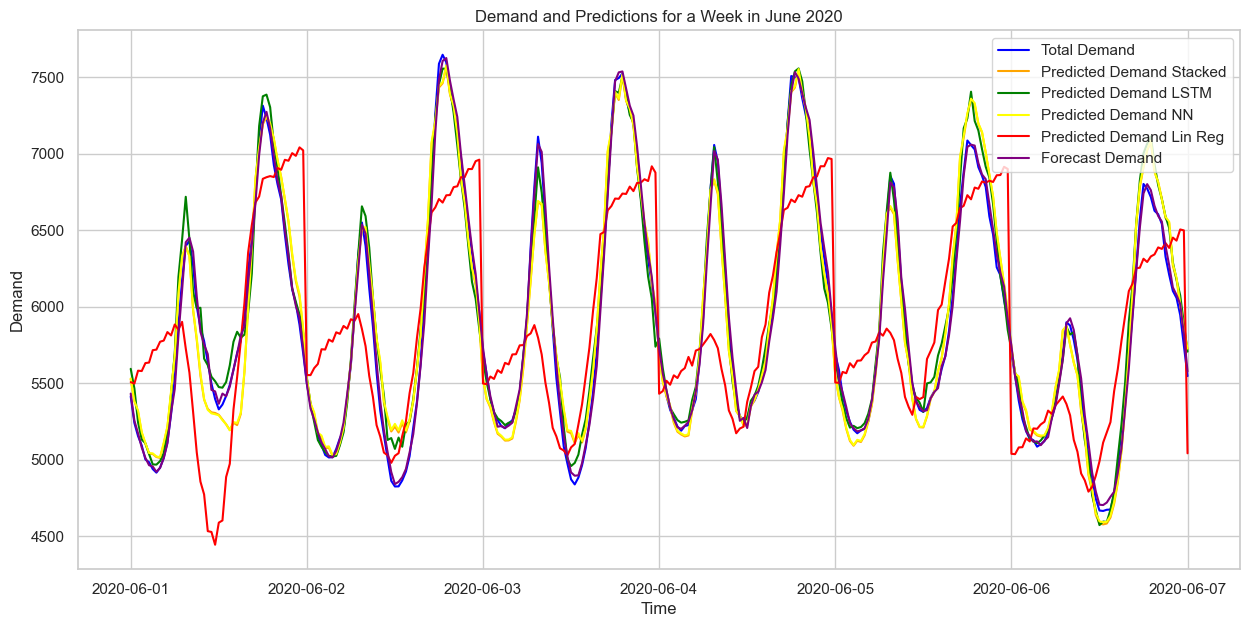

In [42]:
df_qld_merged['DATETIME'] = pd.to_datetime(df_qld_merged['DATETIME'])
weekly_data = complete_merged_df[(df_qld_merged['DATETIME'] >= '2020-06-01') & (df_qld_merged['DATETIME'] <= '2020-06-07')]

weekly_data = weekly_data.dropna(subset=['TOTALDEMAND', 'Stacked_Prediction', 'LSTM_Prediction', 'MLP_Prediction', 'FORECASTDEMAND','Lin_Reg_Prediction'])

dates = weekly_data['DATETIME'].to_numpy()
total_demand = weekly_data['TOTALDEMAND'].to_numpy()
predicted_stacked = weekly_data['Stacked_Prediction'].to_numpy()
predicted_lstm = weekly_data['LSTM_Prediction'].to_numpy()
predicted_nn = weekly_data['MLP_Prediction'].to_numpy()
predicted_lin_reg = weekly_data['Lin_Reg_Prediction'].to_numpy()
forecast_demand = weekly_data['FORECASTDEMAND'].to_numpy()

plt.figure(figsize=(15, 7))
plt.plot(dates, total_demand, color='blue', label='Total Demand')
plt.plot(dates, predicted_stacked, color='orange', label='Predicted Demand Stacked')
plt.plot(dates, predicted_lstm, color='green', label='Predicted Demand LSTM')
plt.plot(dates, predicted_nn, color='yellow', label='Predicted Demand NN')
plt.plot(dates, predicted_lin_reg, color='red', label='Predicted Demand Lin Reg')
plt.plot(dates, forecast_demand, color='purple', label='Forecast Demand')

plt.xlabel('Time')
plt.ylabel('Demand')
plt.title('Demand and Predictions for a Week in June 2020')
plt.legend()
plt.savefig('../report/img/demand_predictions_june_2020.jpg', format='jpeg')
plt.show()


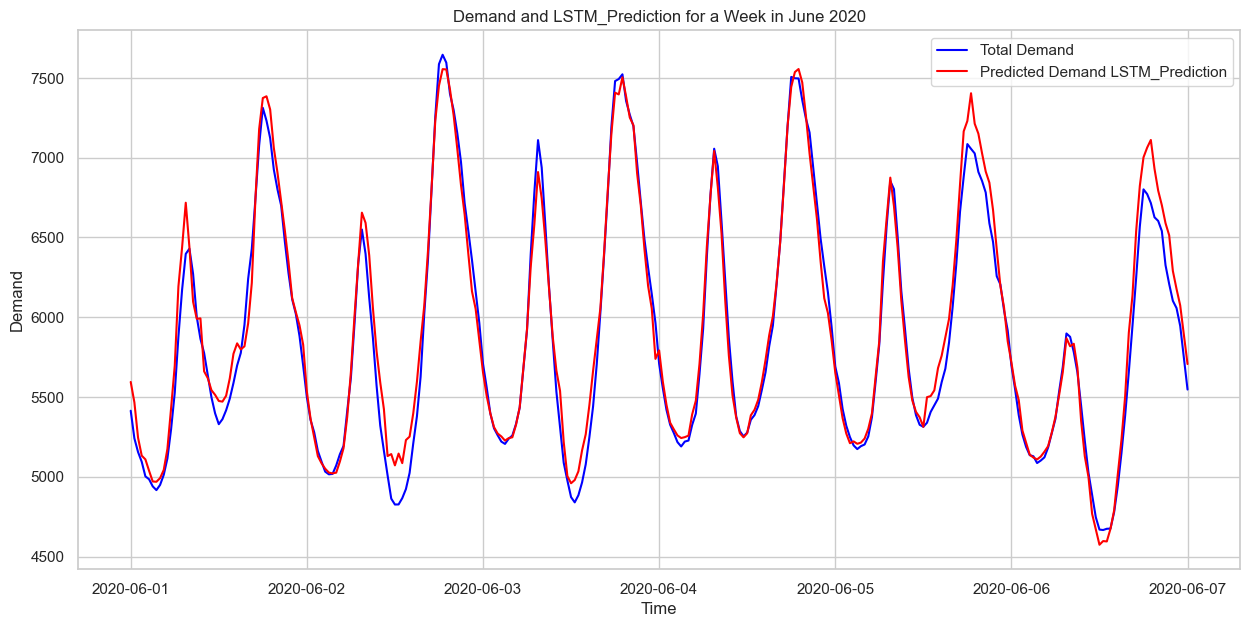

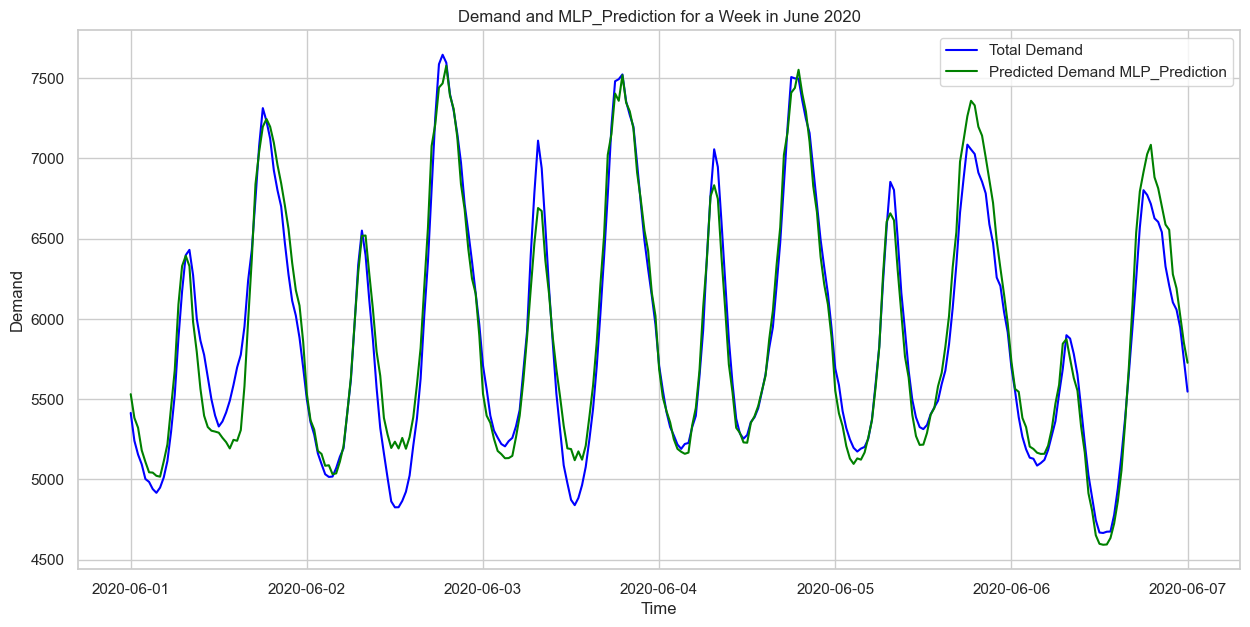

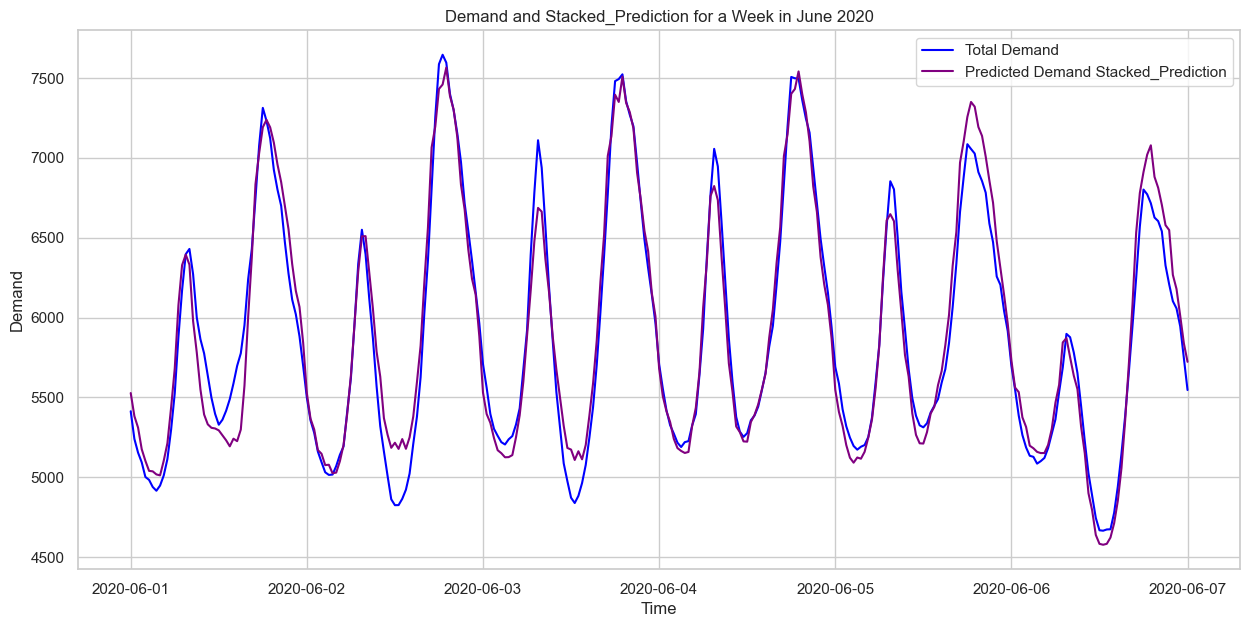

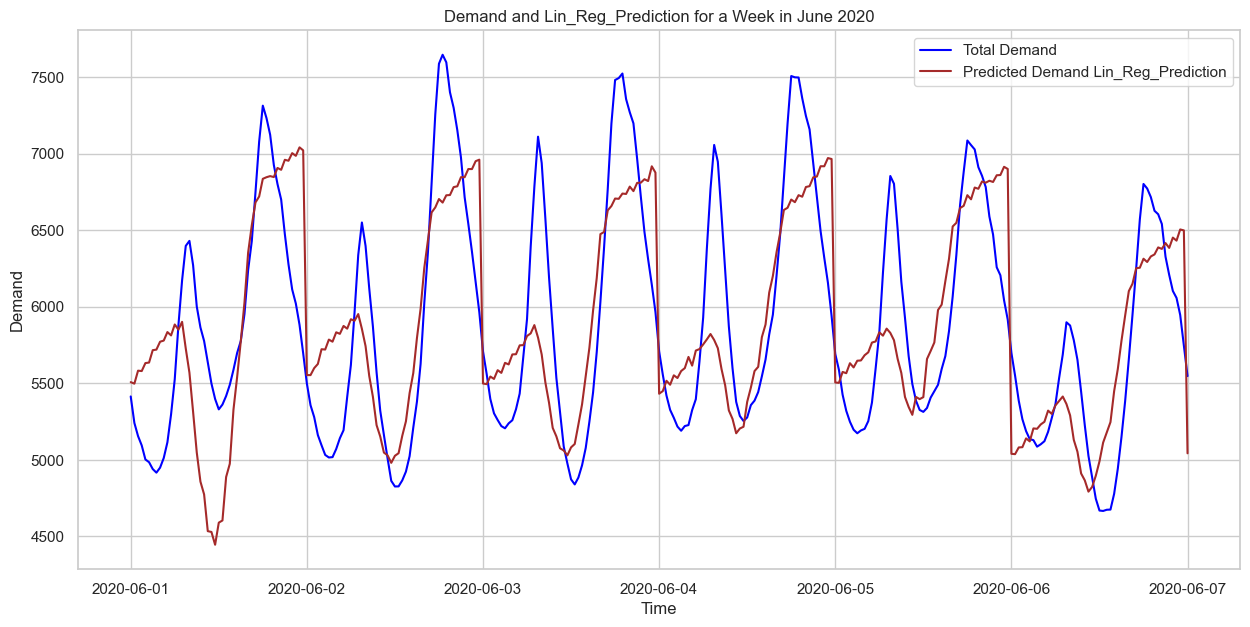

In [144]:
import os
directory_path = '../report/img'


if not os.path.exists(directory_path):
    os.makedirs(directory_path)

prediction_columns = ['LSTM_Prediction', 'MLP_Prediction', 'Stacked_Prediction', 'Lin_Reg_Prediction']
colors = ['red', 'green', 'purple', 'brown']

weekly_data = complete_merged_df[(complete_merged_df['DATETIME'] >= '2020-06-01') & (complete_merged_df['DATETIME'] <= '2020-06-07')]
weekly_data = weekly_data.dropna(subset=['TOTALDEMAND'] + prediction_columns)

dates = weekly_data['DATETIME'].to_numpy()
total_demand = weekly_data['TOTALDEMAND'].to_numpy()

for i, pred_col in enumerate(prediction_columns):
    predicted_values = weekly_data[pred_col].to_numpy()

    plt.figure(figsize=(15, 7))
    plt.plot(dates, total_demand, color='blue', label='Total Demand')
    plt.plot(dates, predicted_values, color=colors[i % len(colors)], label=f'Predicted Demand {pred_col}')

    plt.xlabel('Time')
    plt.ylabel('Demand')
    title = f'Demand and {pred_col} for a Week in June 2020'
    plt.title(title)
    plt.legend()

    
    filename = f'{directory_path}/{pred_col.replace("_", "-").lower()}_june_2020.jpg'
    
    plt.savefig(filename, format='jpeg')

    
    plt.show()

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/2331837307.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


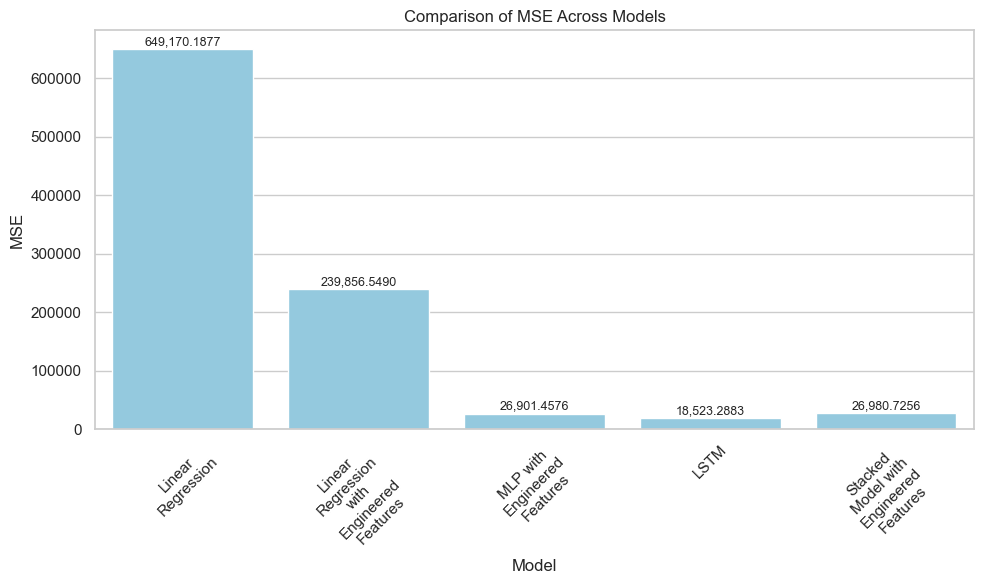

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/2331837307.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


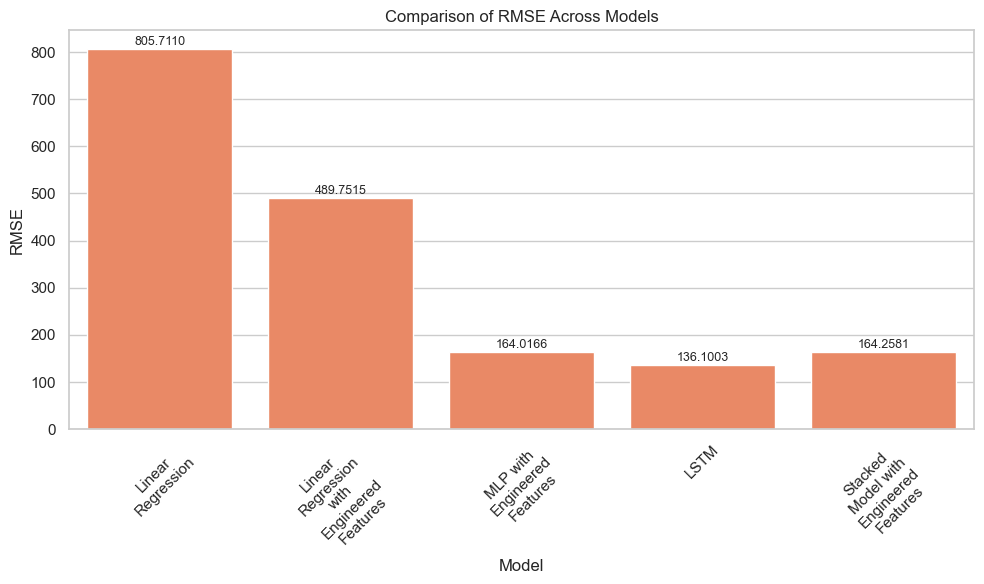

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/2331837307.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


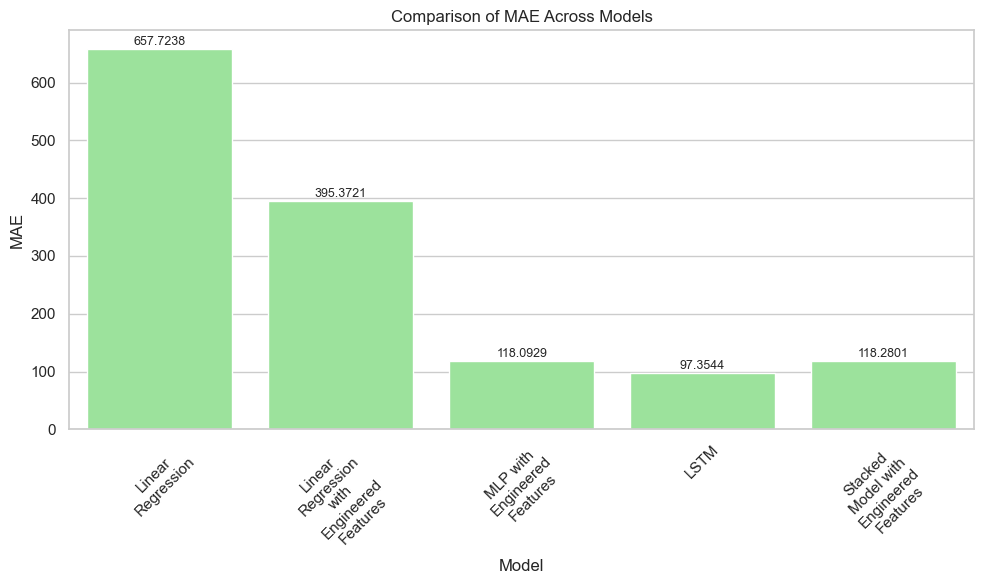

/var/folders/bv/yhyl185564n2bzh9449xdfjw0000gn/T/ipykernel_41994/2331837307.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(new_labels, rotation=45, ha="center")


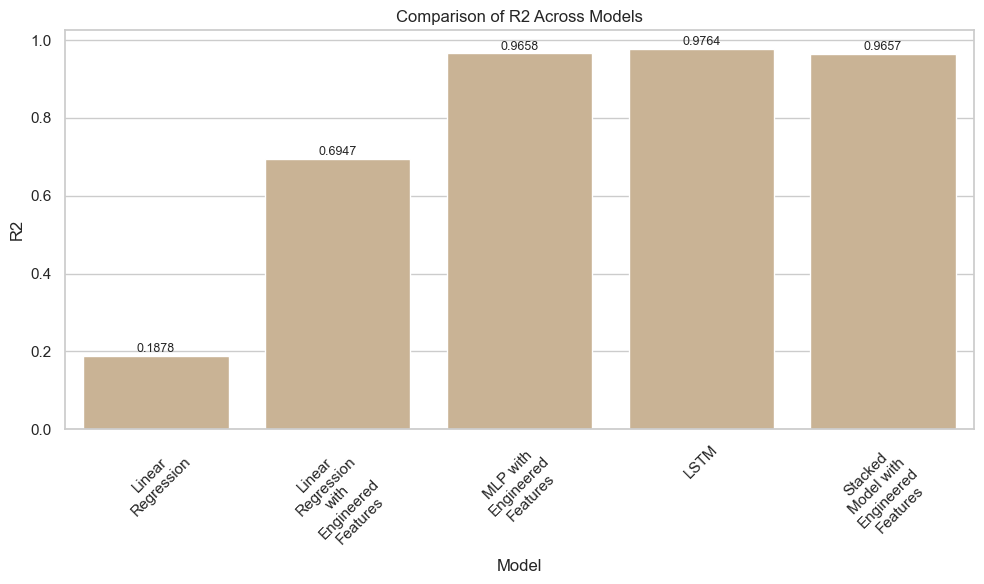

In [46]:

sns.set(style="whitegrid")

metrics = ['MSE', 'RMSE', 'MAE', 'R2']
colors = ['skyblue', 'coral', 'lightgreen', 'tan']


directory_path = '../report/img'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

for i, metric in enumerate(metrics):
    plt.figure(figsize=(10, 6))
    current_color = colors[i % len(colors)]
    barplot = sns.barplot(data=metrics_df, x='Model', y=metric, color=current_color)

    plt.title(f'Comparison of {metric} Across Models')
    plt.ylabel(metric)
    plt.xlabel('Model')

    
    new_labels = ['\n'.join(textwrap.wrap(label.get_text(), 12)) for label in barplot.get_xticklabels()]
    barplot.set_xticklabels(new_labels, rotation=45, ha="center")

    
    for p in barplot.patches:
        height = p.get_height()
        barplot.annotate(f'{height:,.4f}', 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center',
                         size=9,
                         xytext=(0, 5),
                         textcoords='offset points')

    plt.tight_layout()
    
    
    filename = f'{directory_path}/{metric.lower()}_comparison_across_models.jpg'
    plt.savefig(filename, format='jpeg')

    
    plt.show()

In [51]:
metrics_df['MSE'] = metrics_df['MSE'].astype(float)
metrics_df['RMSE'] = metrics_df['RMSE'].astype(float)
metrics_df['MAE'] = metrics_df['MAE'].astype(float)
metrics_df['R2'] = metrics_df['R2'].astype(float)

In [52]:
metrics_df['MSE'] = metrics_df['MSE'].map('{:,.2f}'.format)  # Adding comma for thousands
metrics_df['RMSE'] = metrics_df['RMSE'].map('{:,.2f}'.format)  # Adding comma for thousands
metrics_df['MAE'] = metrics_df['MAE'].map('{:,.2f}'.format)  # Adding comma for thousands
metrics_df['R2'] = metrics_df['R2'].map('{:.5f}'.format)  


In [53]:
metrics_df

Model         MSE    RMSE     MAE  \
0                           Linear Regression  649,170.19  805.71  657.72   
1  Linear Regression with Engineered Features  239,856.55  489.75  395.37   
2                MLP with Engineered Features   26,901.46  164.02  118.09   
3                                        LSTM   18,523.29  136.10   97.35   
4      Stacked Model with Engineered Features   26,980.73  164.26  118.28   

        R2  
0  0.18777  
1  0.69468  
2  0.96576  
3  0.97642  
4  0.96566

## Redoing all the metrics without the Solar PV feature - this will solve the original hypothesis - is Solar a predictive feature?

## Lin Reg Model

In [100]:
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']  

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 342977.48149380274
R^2 Score: 0.5634125379869275


## Adding Metrics to Metrics DF

In [101]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Linear Regression with Engineered Features - Except Solar',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                                       Model            MSE  \
0                                          Linear Regression  649170.187680   
1                 Linear Regression with Engineered Features  239856.549021   
2                               MLP with Engineered Features   26901.457627   
3                              LSTM with Engineered Features   20508.907877   
4                     Stacked Model with Engineered Features   26980.725646   
5  Linear Regression with Engineered Features - Except Solar  342977.481494   

         RMSE         MAE        R2  
0  805.710983  657.723842  0.187767  
1  489.751518  395.372144  0.694679  
2  164.016638  118.092877  0.965756  
3  143.209315  103.194054  0.973894  
4  164.258107  118.280150  0.965655  
5  585.642793  466.783949  0.563413  


## Now the NN

In [102]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=2000, random_state=42))
])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 45649.325960391
R^2 Score: 0.9418914522409697


In [103]:
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'MLP with Engineered Features - Except Solar',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                                       Model            MSE  \
0                                          Linear Regression  649170.187680   
1                 Linear Regression with Engineered Features  239856.549021   
2                               MLP with Engineered Features   26901.457627   
3                              LSTM with Engineered Features   20508.907877   
4                     Stacked Model with Engineered Features   26980.725646   
5  Linear Regression with Engineered Features - Except Solar  342977.481494   
6                MLP with Engineered Features - Except Solar   45649.325960   

         RMSE         MAE        R2  
0  805.710983  657.723842  0.187767  
1  489.751518  395.372144  0.694679  
2  164.016638  118.092877  0.965756  
3  143.209315  103.194054  0.973894  
4  164.258107  118.280150  0.965655  
5  585.642793  466.783949  0.563413  
6  213.657029  152.126860  0.941891  


## LSTM Model

In [104]:
numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.astype(np.float32))
y_train_tensor = torch.tensor(y_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))
y_test_tensor = torch.tensor(y_test.astype(np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # You can adjust this size
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [105]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Here x should have dimensions [batch, 1, features] - adding sequence dimension
        x = x.unsqueeze(1)  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = X_train.shape[1]  # number of features
hidden_dim = 100  # can be changed
num_layers = 2  # number of LSTM layers
output_dim = 1  # one output
num_epochs = 50
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [107]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # If using GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 35574336.0
Epoch 2, Loss: 28691086.0
Epoch 3, Loss: 20115214.0
Epoch 4, Loss: 18606270.0
Epoch 5, Loss: 14073632.0
Epoch 6, Loss: 8337131.5
Epoch 7, Loss: 8879283.0
Epoch 8, Loss: 6994322.5
Epoch 9, Loss: 4724811.5
Epoch 10, Loss: 3346306.75
Epoch 11, Loss: 4453702.5
Epoch 12, Loss: 2795610.25
Epoch 13, Loss: 2739819.0
Epoch 14, Loss: 277672.1875
Epoch 15, Loss: 973235.5
Epoch 16, Loss: 602958.4375
Epoch 17, Loss: 1216635.375
Epoch 18, Loss: 386490.84375
Epoch 19, Loss: 134889.5
Epoch 20, Loss: 163721.734375
Epoch 21, Loss: 158577.296875
Epoch 22, Loss: 111569.4921875
Epoch 23, Loss: 24494.6328125
Epoch 24, Loss: 372516.78125
Epoch 25, Loss: 28222.791015625
Epoch 26, Loss: 58680.34765625
Epoch 27, Loss: 67964.6171875
Epoch 28, Loss: 68390.7890625
Epoch 29, Loss: 20167.6484375
Epoch 30, Loss: 55091.16015625
Epoch 31, Loss: 59882.38671875
Epoch 32, Loss: 20243.423828125
Epoch 33, Loss: 102269.1171875
Epoch 34, Loss: 17369.69921875
Epoch 35, Loss: 13013.2919921875
Epoch 36,

In [108]:
model.eval()  # Set the model to evaluation mode
predictions = []
targets = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.view(-1).tolist())  # Flatten outputs to list
        targets.extend(labels.view(-1).tolist())  # Flatten labels to list

predictions = np.array(predictions)
targets = np.array(targets)

rmse = mean_squared_error(targets, predictions, squared=False)
r2 = r2_score(targets, predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')

RMSE: 162.9477
R^2 Score: 0.9662


/Users/joshuaevans/opt/anaconda3/envs/2024_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [110]:
metrics_df = metrics_df[:-1]

In [111]:

mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)

new_row = pd.DataFrame([{
    'Model': 'LSTM with Engineered Features - Except Solar',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)


                                                       Model            MSE  \
0                                          Linear Regression  649170.187680   
1                 Linear Regression with Engineered Features  239856.549021   
2                               MLP with Engineered Features   26901.457627   
3                              LSTM with Engineered Features   20508.907877   
4                     Stacked Model with Engineered Features   26980.725646   
5  Linear Regression with Engineered Features - Except Solar  342977.481494   
6                MLP with Engineered Features - Except Solar   45649.325960   
7               LSTM with Engineered Features - Except Solar   26551.939535   

         RMSE         MAE        R2  
0  805.710983  657.723842  0.187767  
1  489.751518  395.372144  0.694679  
2  164.016638  118.092877  0.965756  
3  143.209315  103.194054  0.973894  
4  164.258107  118.280150  0.965655  
5  585.642793  466.783949  0.563413  
6  213.657029  152.126

In [112]:

numerical_features = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'TEMPERATURE', 'Heating', 'Cooling']
categorical_features = ['season']
binary_features = ['is_weekend', 'Public_Holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)
    ])

X = complete_merged_df.drop(['TOTALDEMAND'], axis=1)
y = complete_merged_df['TOTALDEMAND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_models = [
    ('lr', Pipeline([('preprocessor', clone(preprocessor)),
                     ('regressor', LinearRegression())])),
    ('gbm', Pipeline([('preprocessor', clone(preprocessor)),
                      ('regressor', GradientBoostingRegressor(random_state=42))])),
    ('mlp', Pipeline([('preprocessor', clone(preprocessor)),
                      ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), 
                                                 activation='relu', 
                                                 solver='adam', 
                                                 max_iter=1000, 
                                                 random_state=42))]))
]

stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

stacked_model.fit(X_train, y_train)

y_pred = stacked_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 45511.436297722925
R^2 Score: 0.942066976586183


In [118]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

new_row = pd.DataFrame([{
    'Model': 'Stacked Model with Engineered Features - Except Solar',
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

print(metrics_df)

                                                       Model            MSE  \
0                                          Linear Regression  649170.187680   
1                 Linear Regression with Engineered Features  239856.549021   
2                               MLP with Engineered Features   26901.457627   
3                              LSTM with Engineered Features   20508.907877   
4                     Stacked Model with Engineered Features   26980.725646   
5  Linear Regression with Engineered Features - Except Solar  342977.481494   
6                MLP with Engineered Features - Except Solar   45649.325960   
7               LSTM with Engineered Features - Except Solar   26551.939535   
8      Stacked Model with Engineered Features - Except Solar   45511.436298   

         RMSE         MAE        R2  
0  805.710983  657.723842  0.187767  
1  489.751518  395.372144  0.694679  
2  164.016638  118.092877  0.965756  
3  143.209315  103.194054  0.973894  
4  164.258107  118.

In [113]:
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
pd.set_option('display.max_rows', None)     # Ensure all rows are shown
pd.set_option('display.max_colwidth', None) # Ensure full display of content in columns
pd.set_option('display.width', None)  

In [137]:
metrics_df

Model            MSE  \
0                                          Linear Regression  649170.187680   
1                 Linear Regression with Engineered Features  239856.549021   
2                               MLP with Engineered Features   26901.457627   
3                              LSTM with Engineered Features   20508.907877   
4                     Stacked Model with Engineered Features   26980.725646   
5  Linear Regression with Engineered Features - Except Solar  342977.481494   
6                MLP with Engineered Features - Except Solar   45649.325960   
7               LSTM with Engineered Features - Except Solar   26551.939535   
8      Stacked Model with Engineered Features - Except Solar   45511.436298   

         RMSE         MAE        R2  
0  805.710983  657.723842  0.187767  
1  489.751518  395.372144  0.694679  
2  164.016638  118.092877  0.965756  
3  143.209315  103.194054  0.973894  
4  164.258107  118.280150  0.965655  
5  585.642793  466.783949  0.563413  
6  213.657029  152.126860  0.941891  
7  162.947659  117.259100  0.966201  
8  213.334095  151.542599  0.942067

In [139]:
print(metrics_df.to_markdown(index=False))

| Model                                                     |      MSE |    RMSE |     MAE |       R2 |
|:----------------------------------------------------------|---------:|--------:|--------:|---------:|
| Linear Regression                                         | 649170   | 805.711 | 657.724 | 0.187767 |
| Linear Regression with Engineered Features                | 239857   | 489.752 | 395.372 | 0.694679 |
| MLP with Engineered Features                              |  26901.5 | 164.017 | 118.093 | 0.965756 |
| LSTM with Engineered Features                             |  20508.9 | 143.209 | 103.194 | 0.973894 |
| Stacked Model with Engineered Features                    |  26980.7 | 164.258 | 118.28  | 0.965655 |
| Linear Regression with Engineered Features - Except Solar | 342977   | 585.643 | 466.784 | 0.563413 |
| MLP with Engineered Features - Except Solar               |  45649.3 | 213.657 | 152.127 | 0.941891 |
| LSTM with Engineered Features - Except Solar              |  2

In [141]:
formatted_metrics_df = metrics_df.copy()
formatted_metrics_df['MSE'] = formatted_metrics_df['MSE'].map('{:,.2f}'.format)
formatted_metrics_df['RMSE'] = formatted_metrics_df['RMSE'].map('{:,.2f}'.format)
formatted_metrics_df['MAE'] = formatted_metrics_df['MAE'].map('{:,.2f}'.format)
formatted_metrics_df['R2'] = formatted_metrics_df['R2'].map('{:,.4f}'.format)


In [143]:
print(formatted_metrics_df.to_markdown(index=False))

| Model                                                     | MSE        |   RMSE |    MAE |     R2 |
|:----------------------------------------------------------|:-----------|-------:|-------:|-------:|
| Linear Regression                                         | 649,170.19 | 805.71 | 657.72 | 0.1878 |
| Linear Regression with Engineered Features                | 239,856.55 | 489.75 | 395.37 | 0.6947 |
| MLP with Engineered Features                              | 26,901.46  | 164.02 | 118.09 | 0.9658 |
| LSTM with Engineered Features                             | 20,508.91  | 143.21 | 103.19 | 0.9739 |
| Stacked Model with Engineered Features                    | 26,980.73  | 164.26 | 118.28 | 0.9657 |
| Linear Regression with Engineered Features - Except Solar | 342,977.48 | 585.64 | 466.78 | 0.5634 |
| MLP with Engineered Features - Except Solar               | 45,649.33  | 213.66 | 152.13 | 0.9419 |
| LSTM with Engineered Features - Except Solar              | 26,551.94  | 162.95 

## Total Metrics DF is complete - Export for posterity and create Deltas for Plotting

In [115]:
metrics_df.to_csv('total_metrics.csv', index=False)


In [116]:
print(metrics_df.dtypes)

Model     object
MSE      float64
RMSE     float64
MAE      float64
R2       float64
dtype: object


In [129]:
def calculate_delta(df, model_name, metrics):
    
    with_solar = df[df['Model'] == f'{model_name} with Engineered Features']
    without_solar = df[df['Model'] == f'{model_name} with Engineered Features - Except Solar']
    
    
    if not with_solar.empty and not without_solar.empty:
        deltas = {metric: (with_solar.iloc[0][metric] - without_solar.iloc[0][metric]) for metric in metrics}
        return deltas
    else:
        return None


models = ['Linear Regression', 'MLP', 'LSTM', 'Stacked Model']


metrics = ['MSE', 'RMSE', 'MAE', 'R2']


deltas = {model: calculate_delta(metrics_df, model, metrics) for model in models}

deltas_df = pd.DataFrame(deltas).T
deltas_df.reset_index(inplace=True)
deltas_df.rename(columns={'index': 'Model'}, inplace=True)

deltas_df

Model            MSE       RMSE        MAE        R2
0  Linear Regression -103120.932473 -95.891276 -71.411805  0.131266
1                MLP  -18747.868333 -49.640391 -34.033984  0.023865
2               LSTM   -6043.031658 -19.738344 -14.065046  0.007692
3      Stacked Model  -18530.710652 -49.075989 -33.262450  0.023588

In [130]:
formatted_deltas_df = deltas_df.copy()
formatted_deltas_df['MSE'] = formatted_deltas_df['MSE'].map('{:,.2f}'.format)
formatted_deltas_df['RMSE'] = formatted_deltas_df['RMSE'].map('{:,.2f}'.format)
formatted_deltas_df['MAE'] = formatted_deltas_df['MAE'].map('{:,.2f}'.format)
formatted_deltas_df['R2'] = formatted_deltas_df['R2'].map('{:,.4f}'.format)

In [131]:
formatted_deltas_df

Model          MSE    RMSE     MAE      R2
0  Linear Regression  -103,120.93  -95.89  -71.41  0.1313
1                MLP   -18,747.87  -49.64  -34.03  0.0239
2               LSTM    -6,043.03  -19.74  -14.07  0.0077
3      Stacked Model   -18,530.71  -49.08  -33.26  0.0236

In [140]:
print(formatted_deltas_df.to_markdown(index=False))

| Model             | MSE         |   RMSE |    MAE |     R2 |
|:------------------|:------------|-------:|-------:|-------:|
| Linear Regression | -103,120.93 | -95.89 | -71.41 | 0.1313 |
| MLP               | -18,747.87  | -49.64 | -34.03 | 0.0239 |
| LSTM              | -6,043.03   | -19.74 | -14.07 | 0.0077 |
| Stacked Model     | -18,530.71  | -49.08 | -33.26 | 0.0236 |


In [123]:
formatted_deltas_df.to_csv('total_metrics_delta.csv', index=False)

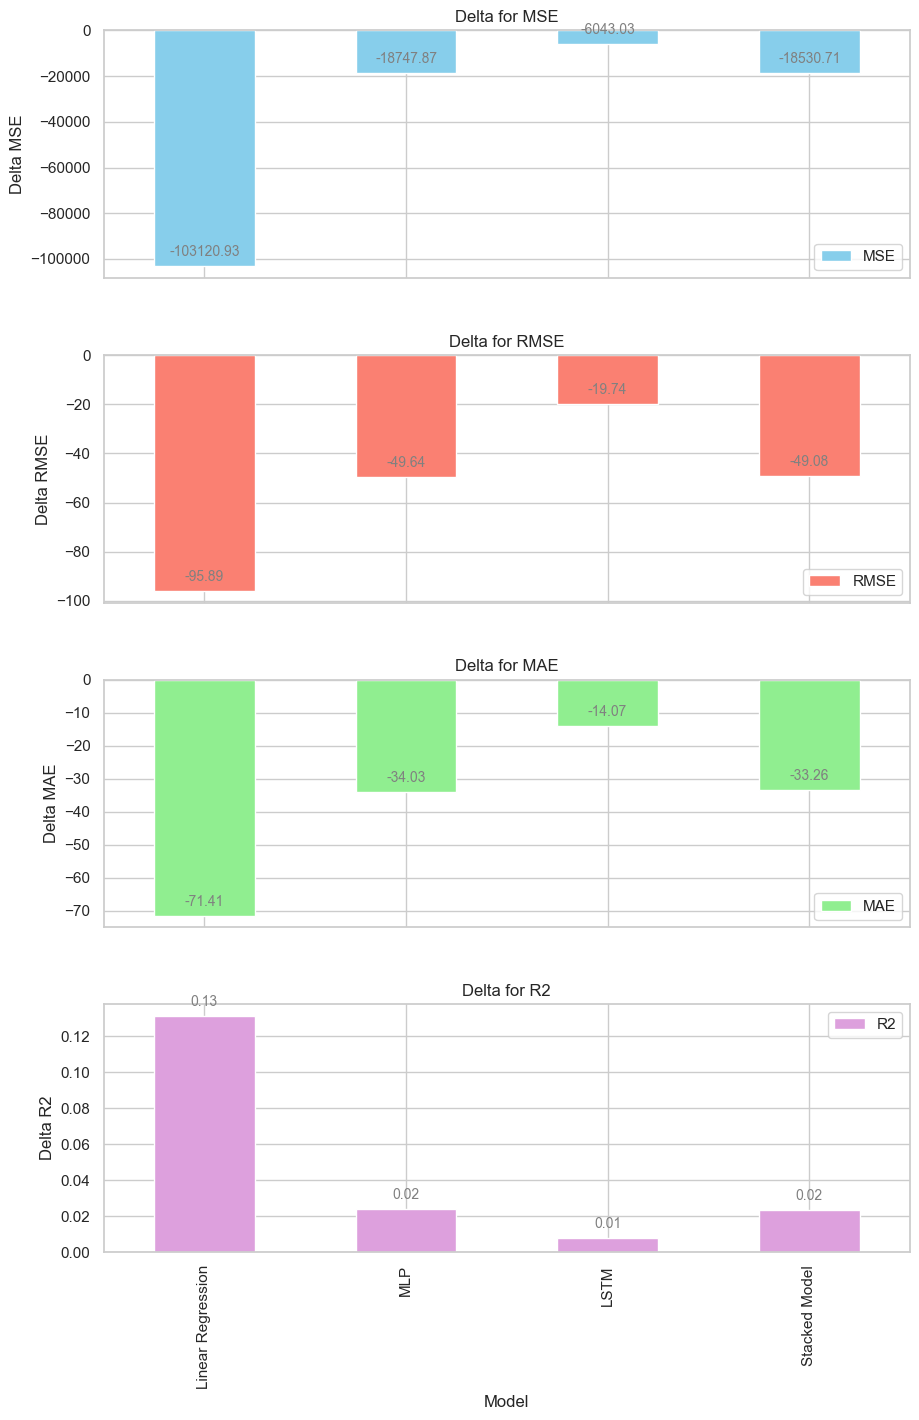

In [136]:
plotting_df = deltas_df.copy()


plotting_df.set_index('Model', inplace=True)

directory_path = '../report/img'

if not os.path.exists(directory_path):
    os.makedirs(directory_path)

fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

metrics = ['MSE', 'RMSE', 'MAE', 'R2']
colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

for ax, metric, color in zip(axs, metrics, colors):
    plotting_df[metric].plot(kind='bar', ax=ax, color=color, label=metric)
    ax.set_title(f'Delta for {metric}')
    ax.set_ylabel(f'Delta {metric}')
    ax.legend()

plt.tight_layout(pad=3.0)

for ax in axs:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=10, color='gray', rotation=0, xytext=(0, 10),
                    textcoords='offset points')


plt.savefig(os.path.join(directory_path, 'deltas_plot.png'))
plt.show()

